## Week 2: Coding Video Notebook


In this notebook, we have four main goals:

* Demonstrate how to do **multi-class classification** using Keras on `sklearn`'s Iris dataset;
* Understand how gradient descent uses **mini-batches** to smooth out the learning process by providing a balance between noisy updates from single examples (stochastic gradient descent) and the computational cost of using the full dataset (batch gradient descent);
* Investigate various possibilities for **optimizers,** such as SGD, RMSProp, and Adam;
* Explore **learning rate schedulers.**

I have provided a larger-than-usual number of appendices to give (optional!) information
about all of these, with code that you may wish to use going forward. 

Whew! That's a lot! So let's get to it!


In [1]:
# Imports and global variables

import numpy as np
import os
import time
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay, CosineDecay, PiecewiseConstantDecay


random_seed = 42

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

## Setting up a basic neural network for multi-class classification on the Iris dataset

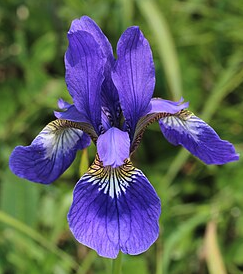


The Iris dataset includes four attributes (features) describing the physical characteristics of iris flowers:

- Sepal length (in centimeters)
- Sepal width (in centimeters)
- Petal length (in centimeters)
- Petal width (in centimeters)

These measurements are used to classify each flower into one of three species:

- Iris setosa
- Iris versicolor
- Iris virginica


### Data Preprocessing



In [2]:
# Load the Iris Dataset, scale, and split

X, y = load_iris(return_X_y=True)

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                    test_size=0.2, 
                                                    random_state=random_seed, 
                                                    stratify=y)  # stratify=y ensures that each class is represented in the same proportion in both the training and test sets.
                                                                 # This leads to more reliable results in classification tasks, especially when datasets are small or classes are imbalanced.

print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (120, 4)
X_test.shape  = (30, 4)
y_train.shape = (120,)
y_test.shape  = (30,)


#### Important question: Is the target one-hot encoded or integer encoded?

It appears that `y_train` has shape `(120,)` (that is, 120 x 1), so it is encoded as integer class labels, so we'll need
to use `sparse_categorical_crossentropy` as our loss function. Let's confirm...

In [3]:
y_train

array([0, 2, 1, 0, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 2, 2, 0, 1, 0,
       2, 0, 1, 2, 2, 0, 2, 0, 0, 1, 1, 0, 2, 2, 1, 1, 2, 1, 0, 1, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 1, 2, 1, 0, 2, 1, 2, 0, 2, 0, 1, 2, 0, 1, 1,
       2, 1, 1, 2, 0, 0, 0, 2, 1, 2, 1, 2, 2, 1, 0, 2, 1, 0, 2, 0, 2, 1,
       1, 0, 1, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 1, 2, 2, 0, 1, 1, 1, 1, 1,
       0, 2, 1, 1, 0, 0, 0, 0, 1, 0])

#### Another important question: Is the dataset balanced (approximately equal number of classes in training set?).

The simplest way to do this for integer labels is to use the `Counter` function, which returns a dictionary giving the frequency of each element in a list. 

In [4]:
Counter(y_train)

Counter({0: 40, 2: 40, 1: 40})

#### Yes,  well balanced!

### Building a Multi-Class Classification Network

Recall that for multi-class classification, we need to use the softmax function to turn the output activations into
a probability distribution, from which we predict the most likely class:

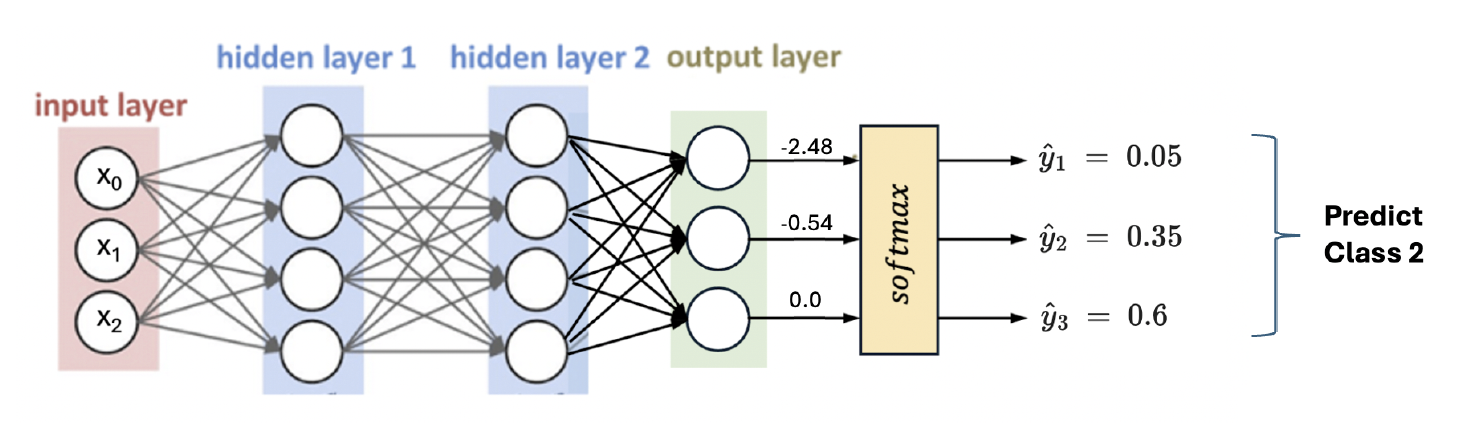

In [5]:
# Here is a simple example of how the softmax function works

activations = np.array([-2.48,-0.54,0.0])

print(softmax(activations))

tf.Tensor([0.05025122 0.34968571 0.60006307], shape=(3,), dtype=float64)


>### Important Digression: What is a tensor?
>
>A **tensor** is like a NumPy array, but with a few important extras. Tensors hold multi-dimensional data just like arrays, but they also:
>
>- Track their **shape** and **data type**
>- Know where they're stored (e.g., **CPU** or **GPU**)
>- Work seamlessly with TensorFlow operations (like layers, loss functions, and gradient computation)
>
>You can convert between NumPy arrays and tensors easily, but tensors are what TensorFlow models expect and use internally.
>
>**Next week we'll explore how to use GPUs in Google Colab and on your own machine.**


## Build the Model

Since this dataset is relatively simple, we'll use a simple network with a single hidden layer with 10 neurons. 

It is an excellent idea to avoid using constants in the input and output layers, since these
can be calculated from the dataset. 

In [7]:
num_features = X_train.shape[1]
print("Number of features:", num_features)

num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

Number of features: 4
Number of classes: 3


In [32]:
# We use Sequential to build a simple classification network from
# a list of layers, and print the summary


iris_model = models.Sequential([
    layers.Input(shape=(num_features,)),             # shape is a tuple (4,) = 1D array of length 4
    layers.Dense(10, activation='relu'),             # small hidden layer
    layers.Dense(num_classes, activation='softmax')  # 3 output classes
])

# Print out layers and stats
iris_model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83 (332.00 B)

 Trainable params: 83 (332.00 B)

 Non-trainable params: 0 (0.00 B)

### Compile the model: specify the loss, optimizer, and any metrics to track.

We use `sparse_categorical_crossentropy` for integer encoded targets and `categorical_crossentropy` for one-hot encodings. 

We'll tend to use the `Adam` **optimizer** as our default, although there are many options (see **Appendix One** for a comparison). The
**learning rate** for Adam has a default of **0.001,** although this is perhaps something to adjust as you tune your network (see **Appendix Two** for
a comparison) or (even better), use a learning rate scheduler.  

In [33]:
opt = Adam(learning_rate=0.001)                               # This is the default

iris_model.compile(loss="sparse_categorical_crossentropy",    # Used for classification with integer encoding of targets
                   optimizer=opt,       
                   metrics=["accuracy"]     
                  ) 

### Training with Mini-Batches

We train the model by repeatedly applying gradient descent to small subsets of the data—called **mini-batches**—over multiple passes (epochs) through the training set.

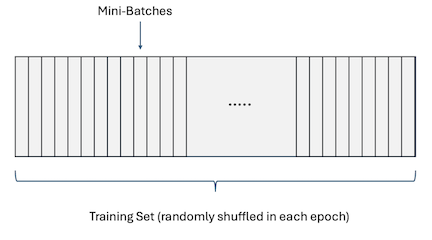

**Training loop (per epoch):**  
1. **Shuffle** the entire training set  
2. **Split** into mini-batches (e.g. 32 samples each)  
3. **Step through each mini-batch**:  
   - **Forward pass:** compute predictions  
   - **Compute loss:** average error over the batch  
   - **Back-propagate:** update all weights immediately, according to the learning rate  
4. **Record** training loss (and any metrics) for this epoch  

`fit` returns a `history` of per-epoch losses and metrics.


#### Why mini-batches?  
- **Efficiency:** vectorized updates on small chunks  
- **Stability:** smoother convergence than pure SGD  
- **Memory:** fits large datasets without holding everything at once  


### Tuning Learning Rate and Batch Size

The **learning rate** and **mini-batch size** are closely related: during training, a weight update occurs after each **step** through a mini-batch, using the learning rate to adjust the weights based on the batch’s gradients.

* If you **decrease the batch size**, updates become **more frequent and noisier**, since each batch contains less data. In this case, you may need to **lower the learning rate** to maintain stable training.
* If you **increase the batch size**, updates become **less frequent but more stable**, allowing for a potentially **larger learning rate** — though this also requires more memory.

In practice:

* **Small batch sizes** (e.g., 16 or 32) can help generalization but often result in **jagged** loss/validation curves.
* **Larger batch sizes** (e.g., 128 or 256) can make training smoother and faster, especially on large datasets or powerful hardware (like GPUs), but may require tuning the learning rate accordingly.

A good rule of thumb:

> Start with a batch size of 32 or 64 and the default learning rate (e.g., `0.001` for `Adam`), then adjust as needed based on training stability and convergence speed.


**Optional:** See **Appendix Three**  for a comparison of different batch sizes while training  on the Iris Dataset.

## Train the model using `fit`

You must specify the training sets, an upper-bound on the number of epochs, the batch size (default is 32, usually works well), and how much information is printed out during training. 

In [34]:
# Set the number of epochs and the batch size for training
epochs = 200
batch_size = 32

iris_history = iris_model.fit(X_train, 
                              y_train, 
                              epochs=epochs,           # Specify the number of iterations of training
                              batch_size=batch_size,     # The mini-batch size, the default size is 32
                              verbose=0                  # Set to 1 to see a trace
                             )

We will discuss **learning curves** more next week, but we can most easily understand the training phase by looking at the statistics stored in the `history` class.

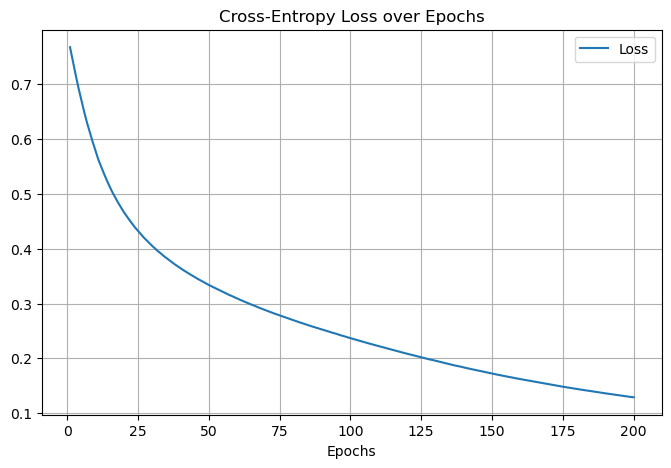

Final Loss: 0.1289


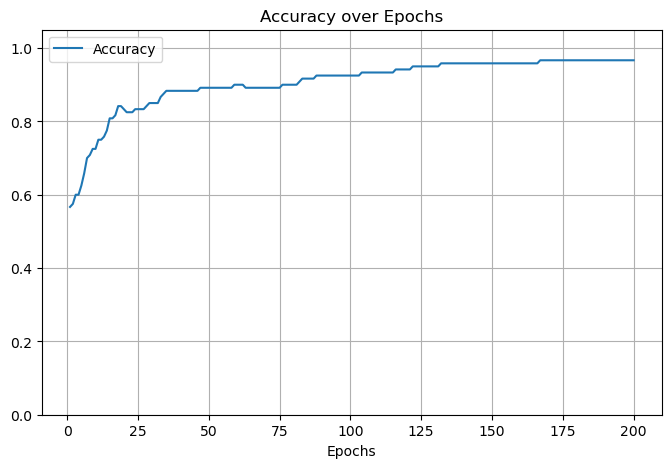

Final Accuracy: 0.9667



In [35]:
# Print out loss and accuracy learning curves

def plot_training(history):
    
    # Plot Loss (RMSE)
    plt.figure(figsize=(8, 5))
    plt.title('Cross-Entropy Loss over Epochs')
    plt.plot(range(1, len(history.history['loss']) + 1),
             history.history['loss'],
             label='Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()
    plt.show()
    
    a = history.history['loss'][-1]
    print(f'Final Loss: {a:.4f}')
    
    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.title('Accuracy over Epochs')
    plt.plot(range(1, len(history.history['loss']) + 1),
             history.history['accuracy'],
             label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylim(0,1.05)
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()
    
    a = history.history['accuracy'][-1]
    print(f'Final Accuracy: {a:.4f}')
    print()

plot_training(iris_history)

## Run on the Test Set

In [36]:
test_loss, test_accuracy = iris_model.evaluate(X_test, y_test,verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1682
Test Accuracy: 0.9333


## Make Predictions

We'll just extract the first two samples from the test set to show how to do predictions. 

Note that `predict` expects a 2D array, i.e., a list of samples, and will return an array of the softmax outputs; you'll need to extract the index of the largest probability to get the predicted class. 

In [13]:
samples = X_test[:2]

print(samples)
print()

y_pred = iris_model.predict(samples,verbose=0)     # y_pred is the softmax output
print(y_pred)
print()

y_pred_class = np.argmax(y_pred, axis=1)          # Find highest probability for predicted class

print(f"True labels: {y_test[:2]}")
print(f"Predicted:   {y_pred_class}")


[[-1.74885626 -0.13197948 -1.39706395 -1.3154443 ]
 [ 0.31099753 -0.13197948  0.64908342  0.79067065]]

[[9.8758286e-01 1.2404387e-02 1.2729721e-05]
 [2.8045531e-03 2.9087287e-01 7.0632255e-01]]

True labels: [0 2]
Predicted:   [0 2]


### Learning Rate Schedulers

Learning rate schedulers are an important tool for tuning deep learning models. In TensorFlow, schedulers can be passed directly as parameters to the optimizer. The general idea is to **start training with a relatively high learning rate**, allowing the model to make large updates when it's far from the optimal solution, and then **gradually reduce the learning rate** to make finer adjustments as the model converges.

One commonly used schedule is **Cosine Decay**, which belongs to a family of methods known as **cosine annealing**. This technique reduces the learning rate smoothly over time, following the shape of a cosine curve. Unlike simple step-based schedules that update once per epoch, `CosineDecay` adjusts the learning rate **after each batch**, making it more precise and effective—especially on larger datasets or longer training runs.

See **Appendix Four** for a comparison of common learning rate schedulers, including code examples, plots of how each strategy adjusts the learning rate over time, and a side-by-side comparison of their performance on our Iris dataset.

To illustrate the technique, we'll now try **cosine decay**, a commonly used scheduler that reduces the learning rate like this:


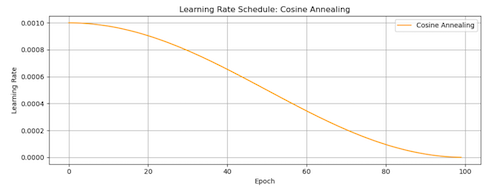

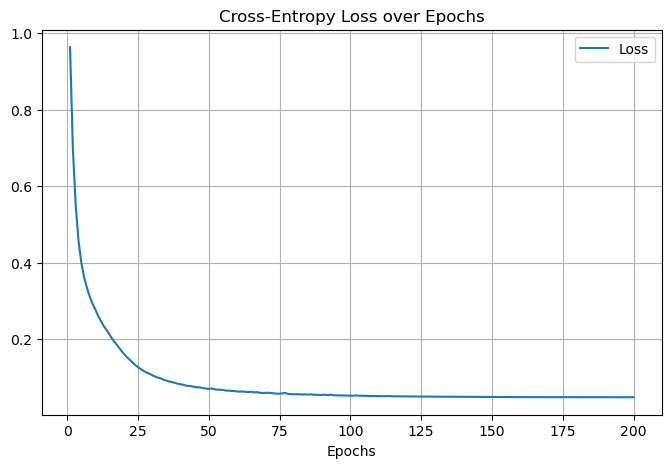

Final Loss: 0.0486


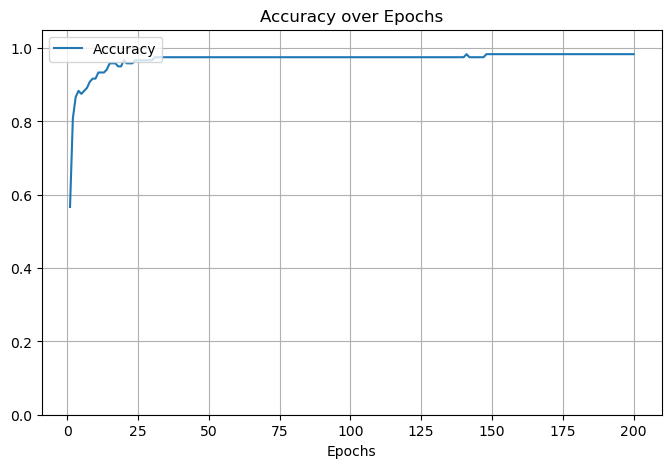

Final Accuracy: 0.9833



In [14]:
# Compute the number of steps (batches) per epoch

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))

# Total number of training steps (needed for per-step schedulers like CosineDecay)

total_steps = epochs * steps_per_epoch

# Start with a slightly higher learning rate (Adam handles this well)
# to allow faster initial progress and to take advantage of the decay schedule

initial_lr = 0.01

# CosineDecay schedule (per-step)
lr_schedule = CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=total_steps,
    alpha=0.0  # Final LR = 0
)

# REMEMBER: IF YOU WANT TO RETRAIN FROM THE BEGINNING, YOU HAVE TO REBUILD THE MODEL!
lr_model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),         # 4 features in the dataset
    layers.Dense(10, activation='relu'),             # small hidden layer
    layers.Dense(num_classes, activation='softmax')  # 3 output classes
])

# Compile with optimizer using the schedule
lr_model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=Adam(learning_rate=lr_schedule),
    metrics=["accuracy"]
)

# Train model (no need for callback now)
lr_history = lr_model.fit(
    X_train, y_train, 
    batch_size=batch_size,
    epochs=epochs,
    verbose=0
)

# Plot training history
plot_training(lr_history)


## Appendix One: Comparison of Different Optimizers

Training with SGD...
Training with Adam...
Training with RMSprop...
Training with Adagrad...


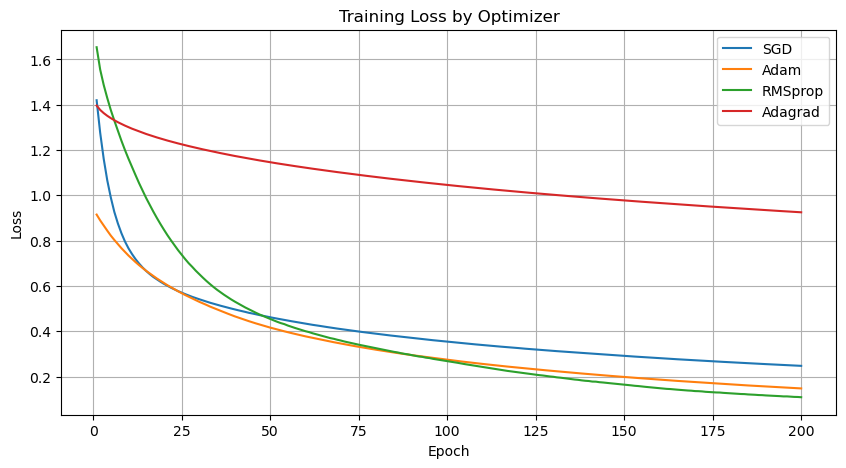

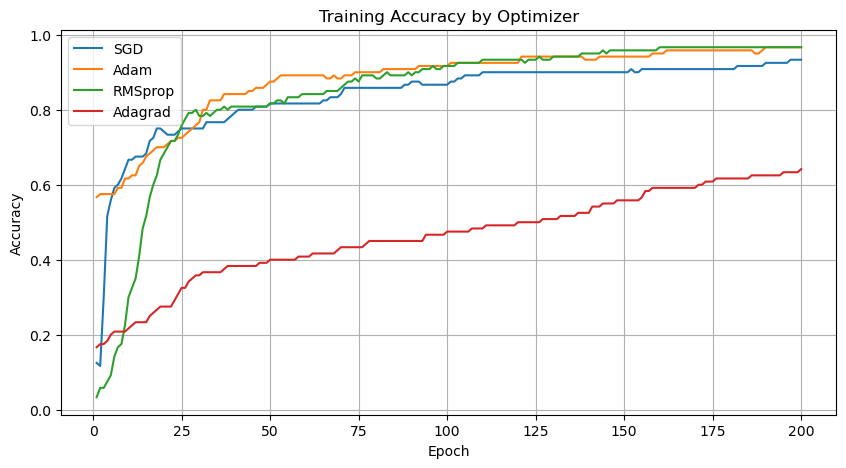

In [15]:
optimizers_to_test = {
    "SGD":      tf.keras.optimizers.SGD(learning_rate=0.01),       # These are the defaults in each case
    "Adam":     tf.keras.optimizers.Adam(learning_rate=0.001),
    "RMSprop":  tf.keras.optimizers.RMSprop(learning_rate=0.001),
    "Adagrad":  tf.keras.optimizers.Adagrad(learning_rate=0.001),
}


loss_dict = {}
acc_dict = {}

for name, opt in optimizers_to_test.items():
    print(f"Training with {name}...")

    # Fresh model for each run
    model = models.Sequential([ layers.Input(shape=(4,)),              # 4 features in the dataset
                                layers.Dense(10, activation='relu'),   # small hidden layer
                                layers.Dense(3, activation='softmax')  # 3 output classes
                              ]
                             )
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        verbose=0
    )

    loss_dict[name] = history.history["loss"]
    acc_dict[name] = history.history["accuracy"]
 
plt.figure(figsize=(10, 5))
for name, losses in loss_dict.items():
    plt.plot(range(1,epochs+1),losses, label=name)

plt.title("Training Loss by Optimizer")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for name, acc in acc_dict.items():
    plt.plot(range(1,epochs+1),acc, label=name)

plt.title("Training Accuracy by Optimizer")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Appendix Two: Adam with Various Learning Rates

`Adam` is the common choice for a wide variety of tasks. Let's see how it performs with different learning rates. 
In general, lower learning rates combined with more training epochs can lead to better convergence—but only up to a point. Be mindful of diminishing returns, where additional training yields little to no improvement.

In [16]:
loss_dict = {}
acc_dict = {}

for lr in tqdm([0.01,0.005,0.001,0.0005,0.0001]):

    # Fresh model for each run
    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),         # 4 features in the dataset
        layers.Dense(10, activation='relu'),             # small hidden layer
        layers.Dense(num_classes, activation='softmax')  # 3 output classes
    ])

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        verbose=0
    )

    loss_dict[lr] = history.history["loss"]
    acc_dict[lr] = history.history["accuracy"]

  0%|          | 0/5 [00:00<?, ?it/s]

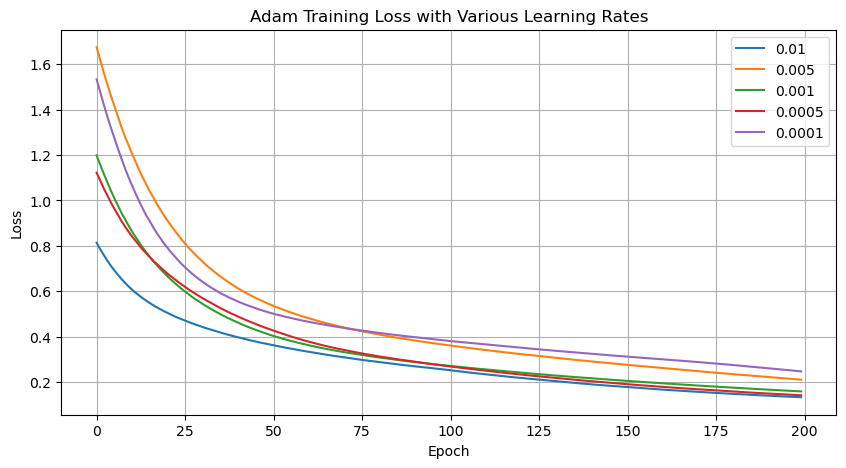

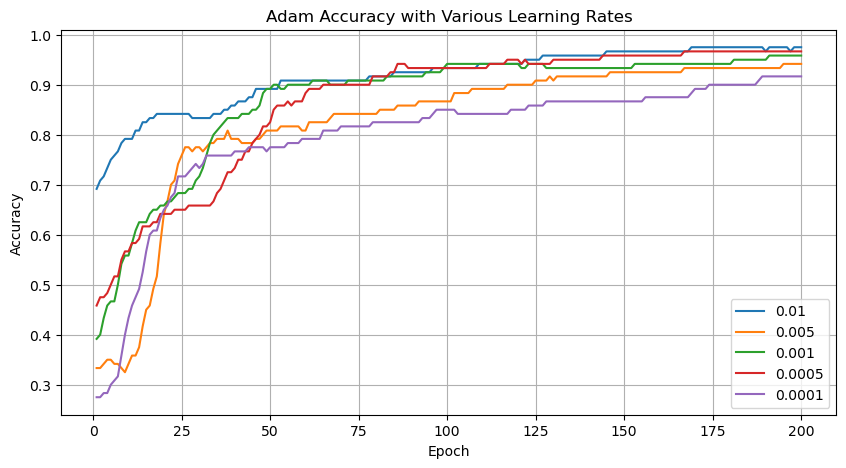

In [17]:
plt.figure(figsize=(10, 5))
for name, losses in loss_dict.items():
    plt.plot(losses, label=name)

plt.title("Adam Training Loss with Various Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for name, acc in acc_dict.items():
    plt.plot(range(1,epochs+1),acc, label=name)

plt.title("Adam Accuracy with Various Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Appendix Three:  Effect of Various Batch Sizes

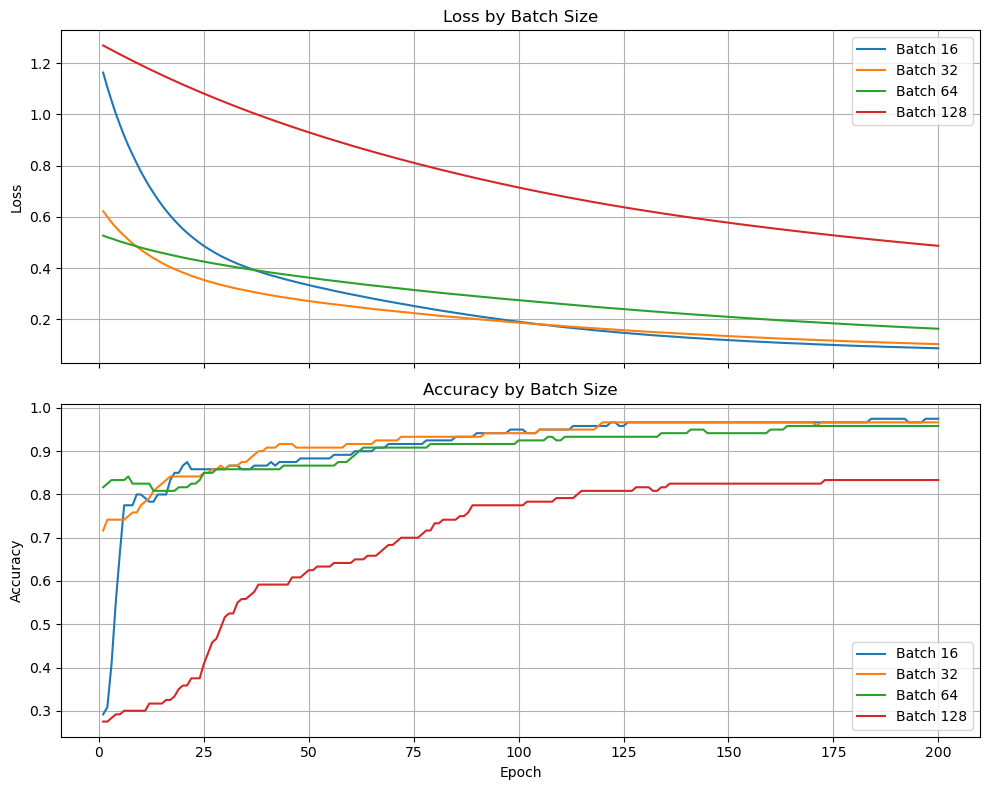

In [18]:
# Train for different batch sizes
batch_sizes = [16, 32, 64, 128]
histories = {}

for batch_size in batch_sizes:
    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),         # 4 features in the dataset
        layers.Dense(10, activation='relu'),             # small hidden layer
        layers.Dense(num_classes, activation='softmax')  # 3 output classes
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=batch_size,
        verbose=0
    )
    histories[batch_size] = history

# Plot learning curves
fig, axs = plt.subplots(2, 1, figsize=(10,8), sharex=True)

for batch_size, history in histories.items():
    axs[0].plot(range(1,epochs+1),history.history['loss'], label=f'Batch {batch_size}')
    axs[1].plot(range(1,epochs+1),history.history['accuracy'], label=f'Batch {batch_size}')

axs[0].set_title('Loss by Batch Size')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].set_title('Accuracy by Batch Size')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

## Appendix Four: Useful Learning Rate Schedulers

Learning rate schedulers are useful tools when you are fine-tuning a network. Each scheduler defines a strategy for adjusting the learning rate over time, typically to allow large updates early in training and smaller, more precise updates as the model converges. This helps speed up training, avoid oscillations, and often leads to better final performance. Here are several common scheduling strategies, with  plots illustrating how they would adjust an initial learning rate 0.001 across 100 epochs:

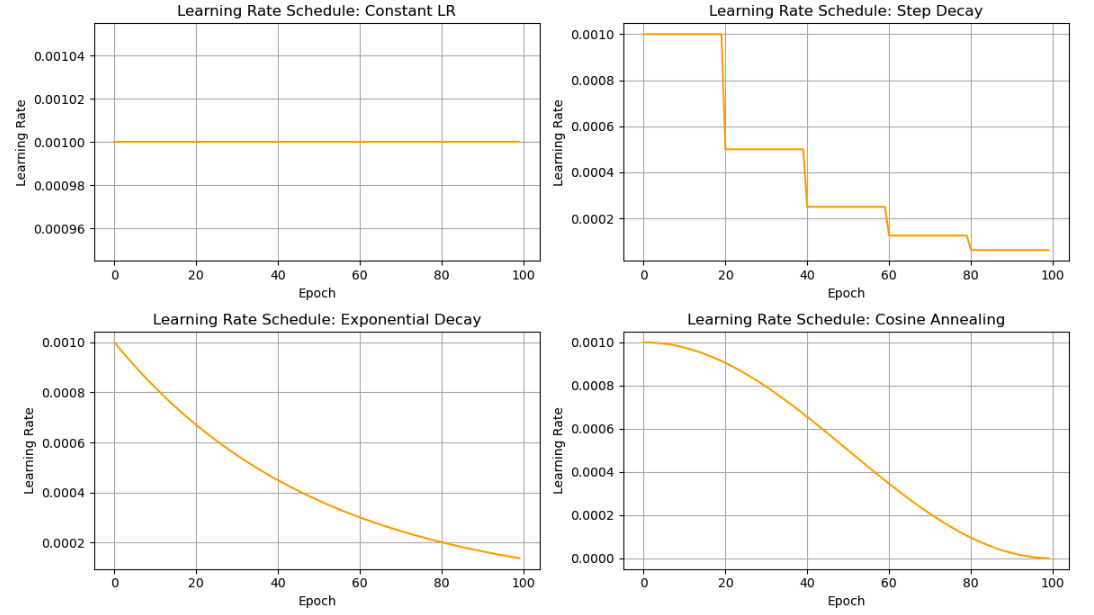

#### Here is a comparison of the various learning rate schedulers running on the Iris Dataset for 200 epochs.

It is generally useful to start these at a somewhat higher learning rate, since they decrease over the total number of epochs. Here, we'll compare them with Adam at
the constant default rate of 0.001. 

Training with Constant...
Training with Step Decay...
Training with Exponential Decay...
Training with Cosine Decay...


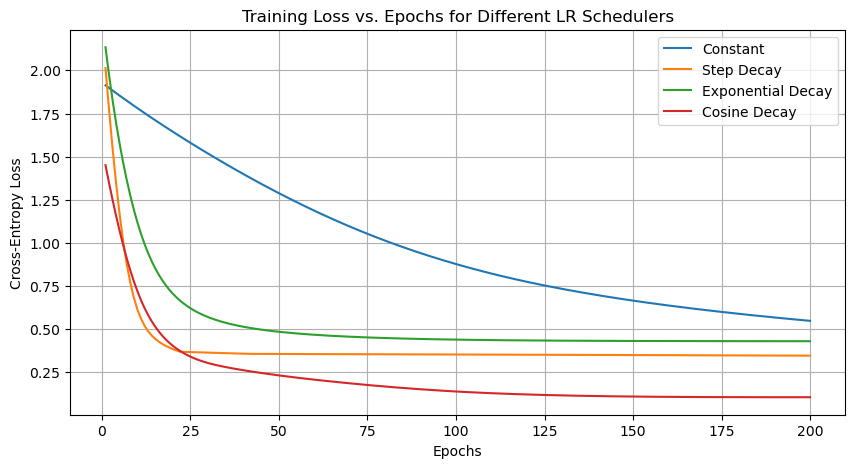

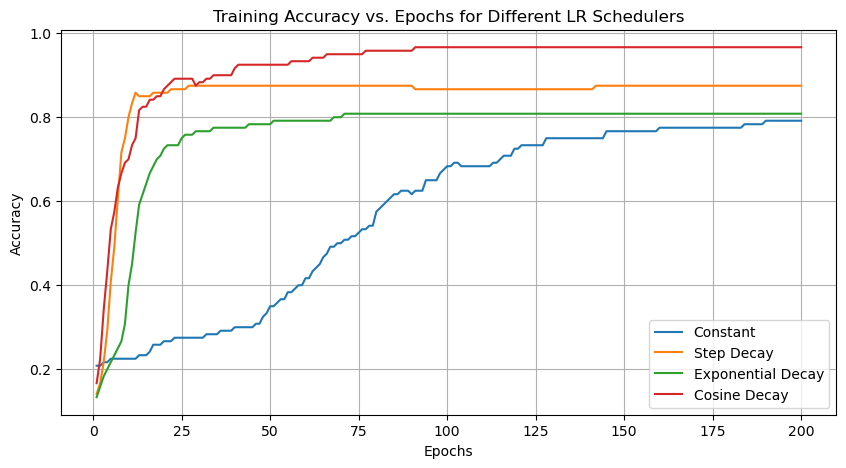

In [19]:
# Training settings

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = epochs * steps_per_epoch
initial_lr = 0.01

# Learning rate schedules
lr_schedulers = {
    "Constant": 0.001,  # Just a float
    "Step Decay": PiecewiseConstantDecay(
        boundaries=[20 * steps_per_epoch, 40 * steps_per_epoch],
        values=[initial_lr, initial_lr * 0.1, initial_lr * 0.01]
    ),
    "Exponential Decay": ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=20 * steps_per_epoch,
        decay_rate=0.5,
        staircase=False
    ),
    "Cosine Decay": CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=total_steps
    )
}

# Store training histories
history_dict = {}

# Training loop for each scheduler
for name, lr_schedule in lr_schedulers.items():
    print(f"Training with {name}...")

    model = models.Sequential([
        layers.Input(shape=(X.shape[1],)),
        layers.Dense(10, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])

    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0
    )

    history_dict[name] = history.history

# Plot training loss
plt.figure(figsize=(10, 5))
for name, hist in history_dict.items():
    plt.plot(range(1,epochs+1),hist['loss'], label=name)
plt.title("Training Loss vs. Epochs for Different LR Schedulers")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot training accuracy
plt.figure(figsize=(10, 5))
for name, hist in history_dict.items():
    plt.plot(range(1,epochs+1), hist['accuracy'], label=name)
plt.title("Training Accuracy vs. Epochs for Different LR Schedulers")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
